In [3]:
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
files = open('index.txt', 'r').read().split('\n')[:-1]
# Cases labeled by certain numbers (2, 12, 13, 14, 15, 17, 81) are duplicated cases except for if condition, will have to be removed.
# For cases with multiple files, we only use those ones with two parts.
useful_idx = open('Useful_Index.txt', 'w+')
for file in files:
    if '81' not in file:
        if file.split('/')[-1].split('.')[-2][-1].isalpha() and file.split('.')[-2][:-1] + 'c.' + file.split('.')[-1] not in files:
            if file.split('.')[-2][:-1] + 'b.' + file.split('.')[-1] in files:
                print('Juliet-Java-v103/' + file, file = useful_idx)
        elif file.split('/')[-1].split('.')[-2][-2:].isnumeric():
            if int(file.split('/')[-1].split('.')[-2][-2:]) not in [j for j in range(2, 12)] + [13, 14, 15, 17]:
                print('Juliet-Java-v103/' + file, file = useful_idx)

# Data Processing Functions

In [4]:
def ExtractGoodAndBad(file):
    f = open(file, 'r').read().split('\n')
    i = 0
    good_lines = []
    bad_lines = []
    while i < len(f):
        if ('private' in f[i].strip() or 'public' in f[i].strip()) and 'bad' in f[i].strip():
            start = i
            j = i
            hit_zero = 1
            count = 0
            #find pairing parentathes
            while hit_zero < 2:
                count += f[j].count('{')
                if '}' in f[j]:
                    count -= f[j].count('}')
                    if count == 0:
                        hit_zero += 1
                j += 1
            end = j + 1
            bad_lines.extend(f[start:end])
            i = j
        i += 1
    # good code instances follows bad code instances
    good_start = end
    good_end = -1
    i = good_start
    while i < len(f):
        # good code instances ends before the main() function
        if '/* Below is the main().' in f[i].strip():
            good_end = i
        i += 1
    if good_end != -1:
        good_lines.extend(f[good_start:good_end])
    return bad_lines, good_lines

'''
# One bad function may related to multiple good functions. Below is the list of all possible names of good functions
good_func_list = {
    'goodG2B',
    'goodB2G',
    'goodB2G1',
    'goodB2G2',
    'goodG2B',
    'goodB2G1',
    'goodB2G2',
    'goodB2G',
    'goodG2B',
    'goodG2B1'   
}
'''

def SplitGoodFunctions(good_lines):
    #return a dictionary of good functions if there are several in one file
    functions = {}
    func_counter = 0
    i = 0
    while i < len(good_lines):
        if ('private' in good_lines[i] or 'public' in good_lines[i]) and 'good' in good_lines[i]:
            if i >= 1 and good_lines[i-1].strip()[:7] == '/* good':
                if good_lines[i-1].strip() not in functions:
                    func_counter += 1
                    functions[good_lines[i-1].strip()] = []
                curr_func = functions[good_lines[i-1].strip()]
                j = i 
                start = j
                count = 0
                hit_zero = 1
                while hit_zero < 2:
                    count += good_lines[j].count('{')
                    if '}' in good_lines[j]:
                        count -= good_lines[j].count('}')
                        if count == 0:
                            hit_zero += 1
                    j += 1
                end = j
                curr_func.extend(good_lines[start: end])
                i = j
        i += 1
    return functions

# remove comments in a function
def RemoveComment(f):
    out = []
    for i in range(len(f)):
        if len(f[i].strip()) > 2:
            if f[i].strip()[:2] not in ['/*', '*/'] and f[i].strip()[0] != '*' and f[i].strip()[-2:] != '*/':
                if '/*' in f[i]:
                    out.append(f[i].split('/*')[0])
                else:
                    out.append(f[i])
                
        else:
            out.append(f[i])
    return '\n'.join(out)

# Remove redundant space
def Cleaning(f):
    syntax_list = ['{', '}', '(', ')', '=', '+', '-', ';', ',', '/', '!=', '==']
    s = ' '.join((' '.join(f.split())).split())
    for syntax in syntax_list:
        s = s.replace(syntax + ' ', syntax)
        s = s.replace(' ' + syntax, syntax)
    return s


In [5]:
useful_files = open('useful_index.txt').read().split('\n')[:-1]

# Test Functions

In [78]:
bad, good = ExtractGoodAndBad(useful_files[3])
print(bad)

000/123/343/CWE113_HTTP_Response_Splitting__Environment_addCookieServlet_16.java
['    public void bad(HttpServletRequest request, HttpServletResponse response) throws Throwable', '    {', '        String data;', '', '        while (true)', '        {', '            /* get environment variable ADD */', '            /* POTENTIAL FLAW: Read data from an environment variable */', '            data = System.getenv("ADD");', '            break;', '        }', '', '        while (true)', '        {', '            if (data != null)', '            {', '                Cookie cookieSink = new Cookie("lang", data);', '                /* POTENTIAL FLAW: Input not verified before inclusion in the cookie */', '                response.addCookie(cookieSink);', '            }', '            break;', '        }', '    }', '']


In [58]:
a = SplitGoodFunctions(good)
print(a)

{'/* goodG2B() - use goodsource and badsink */': ['    private void goodG2B(HttpServletRequest request, HttpServletResponse response) throws Throwable', '    {', '        String data;', '', '        while (true)', '        {', '            /* FIX: Use a hardcoded string */', '            data = "foo";', '            break;', '        }', '', '        while (true)', '        {', '            if (data != null)', '            {', '                Cookie cookieSink = new Cookie("lang", data);', '                /* POTENTIAL FLAW: Input not verified before inclusion in the cookie */', '                response.addCookie(cookieSink);', '            }', '            break;', '        }', '', '    }'], '/* goodB2G() - use badsource and goodsink */': ['    private void goodB2G(HttpServletRequest request, HttpServletResponse response) throws Throwable', '    {', '        String data;', '', '        while (true)', '        {', '            /* get environment variable ADD */', '            /* POTE

In [60]:
print(Cleaning(RemoveComment(bad)))

public void bad(HttpServletRequest request,HttpServletResponse response)throws Throwable{String data;while(true){data=System.getenv("ADD");break;}while(true){if(data!=null){Cookie cookieSink=new Cookie("lang",data);response.addCookie(cookieSink);}break;}}


In [61]:
for key in list(a.keys()):
    print(Cleaning(RemoveComment(a[key])))

private void goodG2B(HttpServletRequest request,HttpServletResponse response)throws Throwable{String data;while(true){data="foo";break;}while(true){if(data!=null){Cookie cookieSink=new Cookie("lang",data);response.addCookie(cookieSink);}break;}}
private void goodB2G(HttpServletRequest request,HttpServletResponse response)throws Throwable{String data;while(true){data=System.getenv("ADD");break;}while(true){if(data!=null){Cookie cookieSink=new Cookie("lang",URLEncoder.encode(data,"UTF-8"));response.addCookie(cookieSink);}break;}}


# Write Data Files

In [6]:
source_file = open('src_data.txt', 'w+')
target_file = open('tgt_data.txt', 'w+')
for i in range(len(useful_files)):
    file = useful_files[i]
    if file.split('.')[0][-1] == 'a':
        bada, gooda = ExtractGoodAndBad(file)
        badb, goodb = ExtractGoodAndBad(useful_files[i + 1])
        bad, good = bada + badb, gooda + goodb
        fname = file.split('/')[-1].split('.')[0][:-1]
    elif file.split('.')[0][-1] == 'b':
        continue
    else:
        bad, good = ExtractGoodAndBad(file)
        fname = file.split('/')[-1].split('.')[0]
    if len(good) > 0:
        good_funcs = SplitGoodFunctions(good)
        bad_cleaned = Cleaning(RemoveComment(bad)).replace(fname, '')
        bad_cleaned = bad_cleaned.replace('bad', 'main')
        for key in good_funcs.keys():
            func_name = key.split()[1][:-2]
            good_cleaned = Cleaning(RemoveComment(good_funcs[key])).replace(fname, '')
            good_cleaned = good_cleaned.replace(func_name, 'main')
            print(good_cleaned, file = target_file)
            print(bad_cleaned, file = source_file)
source_file.close()
target_file.close()

# Statistics

In [1]:
source = open('src_data.txt', 'r').read().split('\n')
target = open('tgt_data.txt', 'r').read().split('\n')
print(len(source), len(target))

23519 23519


In [8]:
def toWordLevel(instance):
    instance = ' '.join(instance.split())
    parser_list_lv1 = ['==', '!=', '&&', '||', '<=', '>=', '>>', '<<']
    parser_list_lv2 = ['!', ';', '=', '+', '-', '&', '%', '*', ':', '.', '|', '/', '(', ')', '{', '}', '[', ']', '<', '>', '\'', '\"', ',', ' ']
    
    parselv1 = []
    while len(instance) > 2:
        i = 0
        while True:
            if instance[i:i+2] in parser_list_lv1:
                if i != 0:
                    parselv1.append(instance[:i])
                parselv1.append(instance[i:i+2])
                instance = instance[i+2:]
                break
            if i == len(instance):
                parselv1.append(instance)
                instance = ''
                break
            i += 1
    parselv2 = []
    for st in parselv1:
        if st not in parser_list_lv1:
            while len(st) > 0:
                i = 0
                while True:
                    if i == len(st):
                        parselv2.append(st)
                        st = ''
                        break
                    if st[i] in parser_list_lv2:
                        if i != 0:
                            parselv2.append(st[:i])
                        parselv2.append(st[i])
                        st = st[i+1:]
                        break
                    i += 1
        else:
            parselv2.append(st)
    return parselv2

In [9]:
src_word = []
tgt_word = []

for instance in source:
    src_word.append(toWordLevel(instance))
    
for instance in target:
    tgt_word.append(toWordLevel(instance))

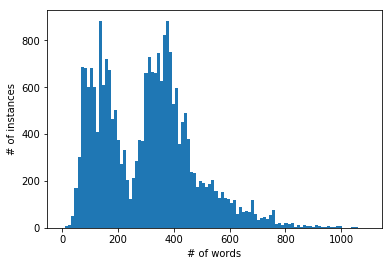

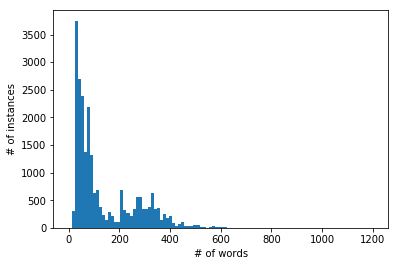

In [10]:
src_len = [len(src_word[i]) for i in range(len(src_word))]
tgt_len = [len(tgt_word[i]) for i in range(len(tgt_word))]
plt.hist(src_len, bins = 100)
plt.xlabel('# of words')
plt.ylabel('# of instances')
plt.show()
plt.hist(tgt_len, bins = 100)
plt.xlabel('# of words')
plt.ylabel('# of instances')
plt.show()

# Create Vocabulary

In [11]:
vocab = {}
for instance in src_word:
    for word in instance:
        if word in vocab: 
            vocab[word] += 1
        else:
            vocab[word] = 1
            
for instance in tgt_word:
    for word in instance:
        if word in vocab: 
            vocab[word] += 1
        else:
            vocab[word] = 1            
print(len(vocab.keys()))
print(list(vocab.keys())[:10])

970
['public', ' ', 'void', 'main', '(', 'HttpServletRequest', 'request', ',', 'HttpServletResponse', 'response']


In [12]:
v_file = open('vocab.txt', 'w+')
for word in vocab.keys():
    print(word, file = v_file)
v_file.close()

# Create Cross_Validation dataset 

In [11]:
random.seed(42)
order = random.sample([i for i in range(len(source))], len(source))

In [15]:
k = 4
for i in range(k):
    test_set = order[i * len(order)//k : (i+1) * len(order)//k]
    train_set = list(set(order) - set(test_set))
    s_file_train = open('src_train%d.txt'%i, 'w+')
    s_file_test = open('src_test%d.txt'%i, 'w+')
    t_file_train = open('tgt_train%d.txt'%i, 'w+')
    t_file_test = open('tgt_test%d.txt'%i, 'w+')
    for n in train_set:
        print(source[n], file = s_file_train)
        print(target[n], file = t_file_train)
    for n in test_set:
        print(source[n], file = s_file_test)
        print(target[n], file = t_file_test)
    s_file_train.close()
    s_file_test.close()
    t_file_train.close()
    t_file_test.close()

0.056407928466796875
